##STEP 1: Defining the Task

###Frame the Problem
The input data is a dataset of 3,000+ images of plastic waste, falling under 6 categories (the dataset is fairly balanced, with each class containing between 500 and 600 images each). 

We are looking at a single-label multi-class classification problem, where we aim to identify the correct categories of the items in the dataset.

Currently, classification of plastic waste is undertaken manually, by people who learn how to visually identify the plastic items by type. I believe that the dataset available contains sufficient information to carry out accurate classification.

###Collect the Dataset
A dataset of 3,186 images falling under 6 categories has been collected.

###Choose a Measure of Success
Accuracy will be used as the main measure of success, as it is a better option than precision and recall for balanced datasets. Precision and recall may be used as secondary measures.

##STEP 2: Developing a Model

###Install Modules

In [ ]:
#General modules
import tensorflow as tf
tf.random.set_seed(0)
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, pathlib
import tensorflow_datasets as tfds
import cv2
import seaborn as sns
import random

#Load the directory
from skimage.transform import resize
from skimage.io import imread

#Train & test the baseline model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers 
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

###Load the Directory

In [ ]:
#Connect to the directory
plasticimagedir = '/content/drive/MyDrive/Plastic_images_dir'
os.chdir(plasticimagedir)
!ls

augmented_classifier.png  LDPE		      PVC
checkpoint_path2.keras	  model_ensemble.pkl  saved_model
checkpoint_path.keras	  OTHER		      simple_classifier.png
cnn_classifier.png	  PET
HDPE			  PP


###Pre-Process the Data/Prepare the Data

In [ ]:
#Categories of plastic types 
Categories=['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC']

#Image size
IMG_SIZE = 64

In [ ]:
#Code adapted from the following sources:
#1. https://www.kaggle.com/code/ashutoshvarma/image-classification-using-svm-92-accuracy
#2. https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01

dataset_arr=[] #input array

#Loop through the categories
for i in Categories:
    print(f'loading... {i}') #display message to show that category is loading
    path=os.path.join(plasticimagedir,i) #join to the image directory
    class_index=Categories.index(i) #subdirectory name which is the inferred label
    class_len=len(os.listdir(path)) #get the number of files per category

    for img in os.listdir(path):
        try:
          img_array=cv2.imread(os.path.join(path,img))
          resized_array=cv2.resize(img_array,(IMG_SIZE, IMG_SIZE)) #resize images
          dataset_arr.append([resized_array,class_index])
        except Exception as e:
          pass
    print(f'loaded {i} successfully:', class_len) #display message to show that category has been loaded successfully

loading... HDPE
loaded HDPE successfully: 520
loading... LDPE
loaded LDPE successfully: 516
loading... OTHER
loaded OTHER successfully: 502
loading... PET
loaded PET successfully: 544
loading... PP
loaded PP successfully: 573
loading... PVC
loaded PVC successfully: 540


In [ ]:
#Shuffle the dataset
random.shuffle(dataset_arr)

In [ ]:
X=[] #array to store the image data
y=[] #array to store the labels
lenofimage = len(dataset_arr)

#loop through the dataset array, and save the image data and labels into separate arrays
#remember in the intial for loop, we saved both the resized array and labels into the dataset array
for imgdata, label in dataset_arr:
    X.append(imgdata)
    y.append(label)

#Display the X and y arrays
y=np.array(y)
X= np.array(X)

print(y.shape)
print(X.shape)

(3195,)
(3195, 64, 64, 3)


In [ ]:
##reshape flattens 64x64x3 array to a vector of 12288 elements
X_2 = X
X = X.reshape((3195, 64 * 64 * 3))

## cast as float and rescale from [0, 1]
X = X.astype('float32')/255
X_2 = X_2.astype('float32')/255

## encode with the convenient to_categorical function
# if you do not encode, the following error occurs: https://stackoverflow.com/questions/67650000/tensorflow-valueerror-shapes-none-1-and-none-10-are-incompatible
y = to_categorical(y)

In [ ]:
#Split the dataset
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=77,stratify=y)
x_train_2,x_test_2,y_train_2,y_test_2=train_test_split(X_2,y,test_size=0.20,random_state=77,stratify=y)

###Choose an Evaluation Protocol
I will use K-fold cross validation for evaluating the original dataset and holdout validation for evaluating the augmented dataset.

### Train and Test Model - No CNN Layers

####Beat a Baseline
The first simple model will be developed using a model sequential API and with the following architecture and parameters:

- Two intermediate Dense layers with relu activation. This combination can tackle a variety of tasks.
- One final Dense layer with a 'softmax' activation. As this is a multi-class classification problem.
- The loss function used is 'categorical_crossentropy.' This is the best loss function for multi-class problems.
- The optimiser used is 'RMSprop' with a default learning rate of 0.001. This is a good choice for a variety of tasks.
- Accuracy is the metric to be measured.
- The batch size chosen is 32, which is a standard size.
- The model will run over 20 epochs.
- Evaluated using k-fold cross validation. 

The baseline to beat is 18% (this is a baseline carried out on a different workbook)

In [ ]:
#all code has been developed with guidance from 'deep learning with python' 
#build a simple model that will do better than a baseline
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(12288,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

#train the model - optimser, loss and metrics are trained at compilation
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])

#validating approach using k-fold cross validation
#validation code adapted from ch5 page 136, deep learning with python
k = 3
num_validation_samples = len(x_train) // k
validation_scores = []

for fold in range(k):
  #selects the validation data partition
  validation_data_x = x_train[num_validation_samples * fold: num_validation_samples * (fold + 1)]
  validation_data_y = y_train[num_validation_samples * fold: num_validation_samples * (fold + 1)]

  #creates a brand new instance of the model (untrained)
  training_data_x = np.concatenate((
    x_train[:num_validation_samples * fold],
    x_train[num_validation_samples * (fold + 1):]))
  
  training_data_y = np.concatenate((
    y_train[:num_validation_samples * fold],
    y_train[num_validation_samples * (fold + 1):]))

  model.fit(training_data_x, training_data_y, epochs= 20, batch_size=32, validation_data=(validation_data_x, validation_data_y))
  validation_score = model.evaluate(validation_data_x, validation_data_y)
  validation_scores.append(validation_score)
validation_score = np.average(validation_scores)

#evaluate the model
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32)

Epoch 1/20
54/54 [==============================] - 7s 18ms/step - loss: 3.5390 - accuracy: 0.1784 - val_loss: 2.6406 - val_accuracy: 0.1549
Epoch 2/20
54/54 [==============================] - 0s 7ms/step - loss: 2.1516 - accuracy: 0.2048 - val_loss: 2.9825 - val_accuracy: 0.1749
Epoch 3/20
54/54 [==============================] - 0s 7ms/step - loss: 2.1606 - accuracy: 0.2165 - val_loss: 2.7131 - val_accuracy: 0.1866
Epoch 4/20
54/54 [==============================] - 0s 5ms/step - loss: 1.8925 - accuracy: 0.2565 - val_loss: 1.9453 - val_accuracy: 0.1984
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 1.8331 - accuracy: 0.2641 - val_loss: 1.9182 - val_accuracy: 0.2347
Epoch 6/20
54/54 [==============================] - 0s 5ms/step - loss: 1.7789 - accuracy: 0.2735 - val_loss: 2.0914 - val_accuracy: 0.2735
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 1.7331 - accuracy: 0.3140 - val_loss: 1.9715 - val_accuracy: 0.1784
Epoch 8/20
54/54 [=

In [ ]:
#evaluating the model on new data
results = model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 3ms/step - loss: 1.1776 - accuracy: 0.5931


In [ ]:
#see the validation score
print(validation_scores)

#See the average validation score
print((validation_scores[0][1] + validation_scores[1][1] + validation_scores[2][1])/3)

[[1.6194841861724854, 0.43661972880363464], [1.6289935111999512, 0.4530516564846039], [1.272377371788025, 0.5469483733177185]]
0.47887325286865234


####Develop a Model that Overfits
As seen above, the training accuracy is 66.04%, however, the average validation accuracy is 47.8% and the testing accuracy is 59.31%.

Below we will develop a model that is generalising but still overfitting to the training data, through tuning key gradient descent parameters, specifically, the learning rate and batch size AND increasing model capacity by adding intermediate layers and using larger layers, allowing the model the freedom to learn more complex representations without any bottlenecks

1. Increasing the batch size from 32 to 64, leading to gradients with lower variance which are more informative
2. Decreasing the learning rate from the default of 0.001 to 0.0001 to improve accuracy.
3. Increasing the number of Dense intermediate layers from 2 to 3.
4. Increasing the size of the Dense intermediate layers from 1 x 32 and 1 x 64 to 2 x 512 and 1 x 64

In [ ]:
#all code has been developed with guidance from 'deep learning with python' 
#build a simple model that will do better than a baseline
model_two = models.Sequential()
model_two.add(layers.Dense(512, activation='relu', input_shape=(12288,)))
model_two.add(layers.Dense(512, activation='relu'))
model_two.add(layers.Dense(64, activation='relu'))
model_two.add(layers.Dense(6, activation='softmax'))

#train the model - optimser, loss and metrics are trained at compilation
model_two.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

#validating approach using k-fold cross validation
#validation code adapted from ch5 page 136, deep learning with python
k = 3
num_validation_samples = len(x_train) // k
validation_scores = []

for fold in range(k):
  #selects the validation data partition
  validation_data_x = x_train[num_validation_samples * fold: num_validation_samples * (fold + 1)]
  validation_data_y = y_train[num_validation_samples * fold: num_validation_samples * (fold + 1)]

  #creates a brand new instance of the model (untrained)
  training_data_x = np.concatenate((
    x_train[:num_validation_samples * fold],
    x_train[num_validation_samples * (fold + 1):]))
  
  training_data_y = np.concatenate((
    y_train[:num_validation_samples * fold],
    y_train[num_validation_samples * (fold + 1):]))

  model_two.fit(training_data_x, training_data_y, epochs= 20, batch_size=64, validation_data=(validation_data_x, validation_data_y))
  validation_score = model.evaluate(validation_data_x, validation_data_y)
  validation_scores.append(validation_score)
validation_score = np.average(validation_scores)

#evaluate the model
history = model_two.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64)

Epoch 1/20
27/27 [==============================] - 2s 22ms/step - loss: 1.9665 - accuracy: 0.1907 - val_loss: 1.8069 - val_accuracy: 0.1925
Epoch 2/20
27/27 [==============================] - 0s 10ms/step - loss: 1.7701 - accuracy: 0.2424 - val_loss: 1.7698 - val_accuracy: 0.1984
Epoch 3/20
27/27 [==============================] - 0s 10ms/step - loss: 1.7608 - accuracy: 0.2283 - val_loss: 1.6997 - val_accuracy: 0.2758
Epoch 4/20
27/27 [==============================] - 0s 11ms/step - loss: 1.6951 - accuracy: 0.3022 - val_loss: 1.5916 - val_accuracy: 0.3791
Epoch 5/20
27/27 [==============================] - 0s 13ms/step - loss: 1.6646 - accuracy: 0.3239 - val_loss: 1.5520 - val_accuracy: 0.3721
Epoch 6/20
27/27 [==============================] - 0s 11ms/step - loss: 1.6238 - accuracy: 0.3498 - val_loss: 1.5677 - val_accuracy: 0.3192
Epoch 7/20
27/27 [==============================] - 0s 11ms/step - loss: 1.5948 - accuracy: 0.3556 - val_loss: 1.5438 - val_accuracy: 0.4308
Epoch 8/20
27

In [ ]:
#see the validation score
print(validation_scores)

#See the average validation score
print((validation_scores[0][1] + validation_scores[1][1] + validation_scores[2][1])/3)

#evaluating the model on new data
results_two = model_two.evaluate(x_test, y_test)
print(results_two)

[[0.8255874514579773, 0.7112675905227661], [0.9365676641464233, 0.6514084339141846], [0.9244377017021179, 0.65727698802948]]
0.6733176708221436
20/20 [==============================] - 0s 4ms/step - loss: 1.1170 - accuracy: 0.6213
[1.1169594526290894, 0.621283233165741]


####Regularize and tune your model
As seen above, the training accuracy has increased from 66.04% to 73.24%, the average validation accuracy from 47.8% to 67.3% and the testing accuracy from 59.31% to 62.13%. There is a 11% difference between the training and testing accuracy, which is indicative of overfitting.

Below we will maximise the generalisation achieved by the overfitting model, while aiming to reduce overfitting. We will do this by:

1. Regularising the model (making it simpler). Reducing the network's size from two intermediate layers of 512 to two intermediate layers of 256.

2. Adding dropout layer of size 0.5.

In [ ]:
#all code has been developed with guidance from 'deep learning with python' 
#build a simple model that will do better than a baseline
model_three = models.Sequential()
model_three.add(layers.Dense(256, activation='relu', input_shape=(12288,)))
model_three.add(layers.Dense(256, activation='relu'))
model_three.add(layers.Dense(64, activation='relu'))
model_three.add(layers.Dropout(0.5))
model_three.add(layers.Dense(6, activation='softmax'))

#train the model - optimser, loss and metrics are trained at compilation
model_three.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

#validating approach using k-fold cross validation
#validation code adapted from ch5 page 136, deep learning with python
k = 3
num_validation_samples = len(x_train) // k
validation_scores = []

for fold in range(k):
  #selects the validation data partition
  validation_data_x = x_train[num_validation_samples * fold: num_validation_samples * (fold + 1)]
  validation_data_y = y_train[num_validation_samples * fold: num_validation_samples * (fold + 1)]

  #creates a brand new instance of the model (untrained)
  training_data_x = np.concatenate((
    x_train[:num_validation_samples * fold],
    x_train[num_validation_samples * (fold + 1):]))
  
  training_data_y = np.concatenate((
    y_train[:num_validation_samples * fold],
    y_train[num_validation_samples * (fold + 1):]))

  model_three.fit(training_data_x, training_data_y, epochs= 20, batch_size=64, validation_data=(validation_data_x, validation_data_y))
  validation_score = model.evaluate(validation_data_x, validation_data_y)
  validation_scores.append(validation_score)
validation_score = np.average(validation_scores)

#evaluate the model
history = model_three.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64)

Epoch 1/20
27/27 [==============================] - 2s 22ms/step - loss: 1.9119 - accuracy: 0.1590 - val_loss: 1.7856 - val_accuracy: 0.2066
Epoch 2/20
27/27 [==============================] - 0s 10ms/step - loss: 1.8031 - accuracy: 0.1796 - val_loss: 1.7832 - val_accuracy: 0.2512
Epoch 3/20
27/27 [==============================] - 0s 8ms/step - loss: 1.7904 - accuracy: 0.1843 - val_loss: 1.7450 - val_accuracy: 0.2934
Epoch 4/20
27/27 [==============================] - 0s 8ms/step - loss: 1.7675 - accuracy: 0.2148 - val_loss: 1.7076 - val_accuracy: 0.4120
Epoch 5/20
27/27 [==============================] - 0s 7ms/step - loss: 1.7412 - accuracy: 0.2359 - val_loss: 1.6625 - val_accuracy: 0.3650
Epoch 6/20
27/27 [==============================] - 0s 7ms/step - loss: 1.7354 - accuracy: 0.2453 - val_loss: 1.6668 - val_accuracy: 0.3697
Epoch 7/20
27/27 [==============================] - 0s 7ms/step - loss: 1.7167 - accuracy: 0.2606 - val_loss: 1.6774 - val_accuracy: 0.3099
Epoch 8/20
27/27 [

In [ ]:
#see the validation score
print(validation_scores)

#See the average validation score
print((validation_scores[0][1] + validation_scores[1][1] + validation_scores[2][1])/3)

#evaluating the model on new data
results_three = model_three.evaluate(x_test, y_test)
print(results_three)

[[0.8255874514579773, 0.7112675905227661], [0.9365676641464233, 0.6514084339141846], [0.9244377017021179, 0.65727698802948]]
0.6733176708221436
20/20 [==============================] - 0s 4ms/step - loss: 1.1412 - accuracy: 0.5947
[1.1412426233291626, 0.5946791768074036]


The training accuracy is 62.75%, the testing accuracy is 59.47%, and the validation accuracy is 67.33%. Overfitting has been significantly reduced.

###Train and Test Model - CNN Layers ⭐

In [ ]:
#Code adapted from deep learning with python, page 189
#Below we are using the Callback argument, which will be passed to the fit method

#Callbacks - Early Stopping
callbacks_list = [
  #Interrupts training when improvement stops, for 20 epochs
  keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=15,
  ),

#Callbacks - Model Checkpoint
  #Saves the current weights after each epoch
  keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path2.keras",
    monitor="val_loss",
    save_best_only=True,
  ),

  #https://keras.io/api/callbacks/reduce_lr_on_plateau/
  #Callbacks - Reduce learning rate on plateau
  keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    min_lr=0.00001,
  )
]

In [ ]:
#build the network
inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(6, activation="softmax")(x)

#instantiate the the model by specifying its inputs and outputs in the Model constructor
model_four = keras.Model(inputs=inputs, outputs=outputs)
model_four.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                           

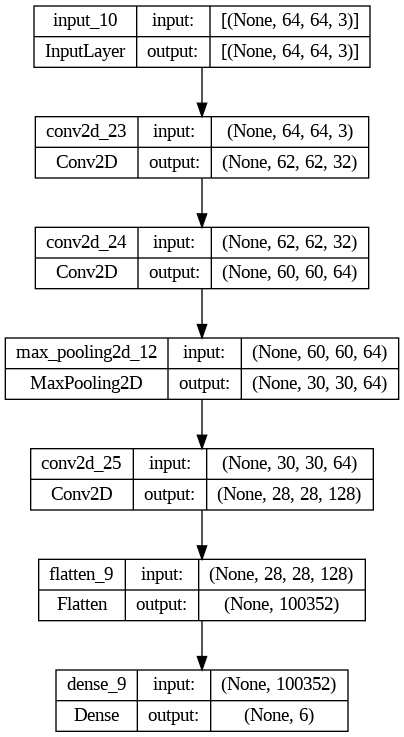

In [ ]:
#visualising the connectivity of the model/topology of the model
keras.utils.plot_model(model_four, "simple_classifier.png", show_shapes=True)

In [ ]:
#optimser, loss and metrics are trained at compilation
model_four.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
## training - fit input to data
#note that validation data needs to be passed to the call, as we are monitoring this
#As k-fold validation does not give validation data to test on, holdout validation is needed

#validating your approach - split the training set into a validation set (10000 samples) and training set (40000 samples)
x_val = x_train_2[:500]
partial_x_train = x_train_2[500:]

y_val = y_train_2[:500]
partial_y_train = y_train_2[500:]

history = model_four.fit(partial_x_train, partial_y_train, 
                         epochs=100, 
                         batch_size = 64, 
                         callbacks=callbacks_list,
                         validation_data=(x_val, y_val))

Epoch 1/100
33/33 [==============================] - 4s 89ms/step - loss: 1.7291 - accuracy: 0.2592 - val_loss: 1.6994 - val_accuracy: 0.1820 - lr: 1.0000e-04
Epoch 2/100
33/33 [==============================] - 1s 25ms/step - loss: 1.5152 - accuracy: 0.4363 - val_loss: 1.5115 - val_accuracy: 0.3300 - lr: 1.0000e-04
Epoch 3/100
33/33 [==============================] - 1s 21ms/step - loss: 1.3502 - accuracy: 0.5199 - val_loss: 1.5289 - val_accuracy: 0.3420 - lr: 1.0000e-04
Epoch 4/100
33/33 [==============================] - 1s 25ms/step - loss: 1.2299 - accuracy: 0.5632 - val_loss: 1.2517 - val_accuracy: 0.5220 - lr: 1.0000e-04
Epoch 5/100
33/33 [==============================] - 1s 23ms/step - loss: 1.1592 - accuracy: 0.5890 - val_loss: 1.1611 - val_accuracy: 0.5820 - lr: 1.0000e-04
Epoch 6/100
33/33 [==============================] - 1s 21ms/step - loss: 1.0972 - accuracy: 0.6235 - val_loss: 1.3583 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 7/100
33/33 [===========================

In [ ]:
test_loss, test_acc = model_four.evaluate(x_test_2, y_test_2)

20/20 [==============================] - 0s 7ms/step - loss: 0.7674 - accuracy: 0.7371


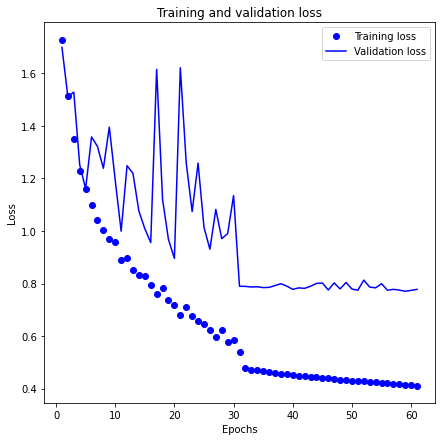

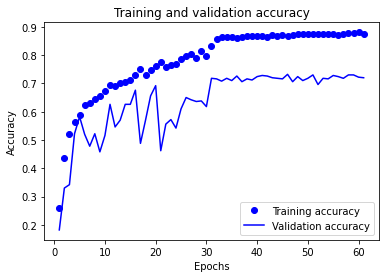

In [ ]:
#all code has been developed with guidance from 'deep learning with python' 

#see the history of the training
history_dict = history.history

#plot the validation and training loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.figure(figsize=(7, 7))
plot1 = plt.plot(epochs, loss_values, 'bo', label='Training loss') #bo is for blue dot
plot1 = plt.plot(epochs, val_loss_values, 'b', label='Validation loss') #b is for solid blue line
plot1 = plt.title('Training and validation loss')
plot1= plt.xlabel('Epochs')
plot1 = plt.ylabel('Loss')
plot1 = plt.legend()
plot1 = plt.show()

#plot the validation and training accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plot2 = plt.plot(epochs, acc, 'bo', label='Training accuracy')
plot2 = plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plot2 = plt.title('Training and validation accuracy')
plot2 = plt.xlabel('Epochs')
plot2 = plt.ylabel('Accuracy')
plot2 = plt.legend()
plot2 = plt.show()

###Train and Test Model - Augmented ⭐⭐

In [ ]:
#data augmentation
data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal_and_vertical"),
#layers.RandomRotation(0.05),
#layers.RandomZoom(0.1),
#layers.RandomTranslation((0.1), (0.1),),
#layers.RandomContrast(0.2),
])

In [ ]:
#Load image directory
dataset = tf.keras.utils.image_dataset_from_directory(
    plasticimagedir,
    shuffle = True,
    seed=123,
    image_size = (150, 150),
    batch_size = 32
)

#Get the class names using the class_names attribute on the dataset
class_names = dataset.class_names
print(class_names)

Found 3195 files belonging to 7 classes.
['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC', 'saved_model']


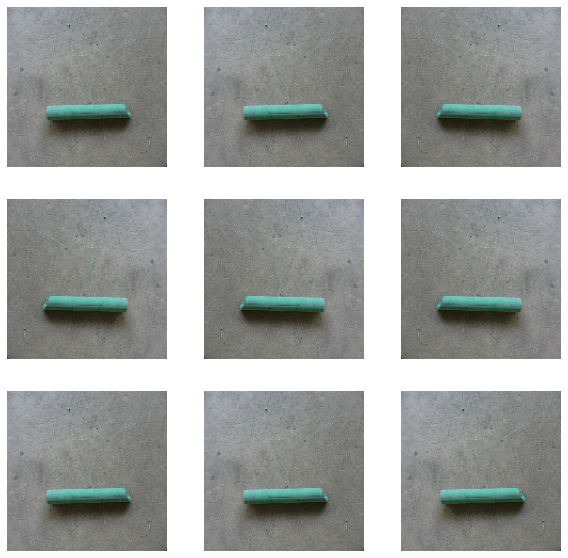

In [ ]:
#Code adapated from deep learning with python, pg 222
#Visualise augmented images
plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [ ]:
#build the network
inputs = keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)

#instantiate the the model by specifying its inputs and outputs in the Model constructor
model_five = keras.Model(inputs=inputs, outputs=outputs)
model_five.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                           

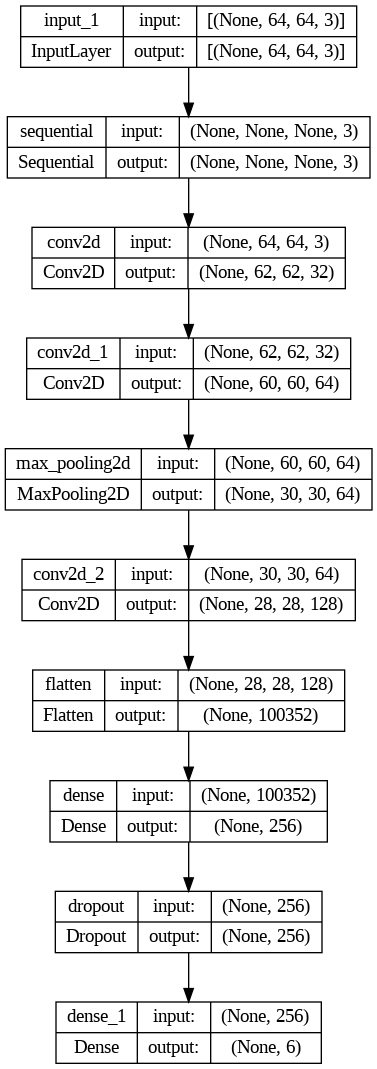

In [ ]:
#visualising the connectivity of the model/topology of the model
keras.utils.plot_model(model_five, "augmented_classifier.png", show_shapes=True)

In [ ]:
#optimser, loss and metrics are trained at compilation
model_five.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
#validating your approach - split the training set into a validation set (10000 samples) and training set (40000 samples)
x_val = x_train_2[:500]
partial_x_train = x_train_2[500:]

y_val = y_train_2[:500]
partial_y_train = y_train_2[500:]

history = model_five.fit(partial_x_train, partial_y_train, 
                         epochs=54, 
                         batch_size = 64, 
                         validation_data=(x_val, y_val))

Epoch 1/54
33/33 [==============================] - 2s 53ms/step - loss: 0.3121 - accuracy: 0.8959 - val_loss: 0.8947 - val_accuracy: 0.7040
Epoch 2/54
33/33 [==============================] - 2s 58ms/step - loss: 0.3091 - accuracy: 0.9042 - val_loss: 0.8105 - val_accuracy: 0.7280
Epoch 3/54
33/33 [==============================] - 1s 42ms/step - loss: 0.2935 - accuracy: 0.9047 - val_loss: 0.8719 - val_accuracy: 0.6980
Epoch 4/54
33/33 [==============================] - 1s 41ms/step - loss: 0.2683 - accuracy: 0.9193 - val_loss: 0.7585 - val_accuracy: 0.7560
Epoch 5/54
33/33 [==============================] - 1s 38ms/step - loss: 0.2507 - accuracy: 0.9202 - val_loss: 0.8193 - val_accuracy: 0.7500
Epoch 6/54
33/33 [==============================] - 1s 38ms/step - loss: 0.2602 - accuracy: 0.9110 - val_loss: 0.8515 - val_accuracy: 0.7240
Epoch 7/54
33/33 [==============================] - 1s 39ms/step - loss: 0.2831 - accuracy: 0.9076 - val_loss: 0.8429 - val_accuracy: 0.7380
Epoch 8/54
33

In [ ]:
test_loss_two, test_acc_two = model_five.evaluate(x_test_2, y_test_2)

20/20 [==============================] - 0s 7ms/step - loss: 0.9830 - accuracy: 0.7872


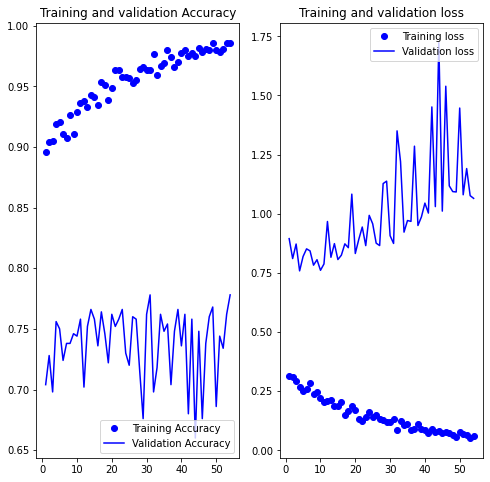

In [ ]:
#see the history of the training
history_dict = history.history

#plot the validation and training loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

#plot the validation and training accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy') #bo is for blue dot
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') #b is for solid blue line
plt.legend(loc="lower right")
plt.title('Training and validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_values, 'bo', label='Training loss') #bo is for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') #b is for solid blue line
plt.legend(loc="upper right")
plt.title('Training and validation loss')

plt.show()

In [ ]:
#Code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#print classification report for CNN
preds = np.round(model_five.predict(x_test_2), 0)

#print classification report
classification_metrics = metrics.classification_report(y_test_2, preds, target_names = Categories)
print(classification_metrics)

20/20 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

        HDPE       0.74      0.88      0.80       104
        LDPE       0.71      0.65      0.68       103
       OTHER       0.84      0.81      0.82       100
         PET       0.72      0.73      0.73       109
          PP       0.88      0.70      0.78       115
         PVC       0.92      0.89      0.91       108

   micro avg       0.80      0.78      0.79       639
   macro avg       0.80      0.78      0.79       639
weighted avg       0.80      0.78      0.79       639
 samples avg       0.78      0.78      0.78       639



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


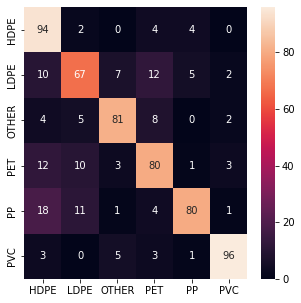

In [ ]:
#Categorical code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#Change into categorical variables
categorical_test_labels = pd.DataFrame(y_test_2).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

#print the confusion matrix as an image
confmat_1 = confusion_matrix(categorical_test_labels, categorical_preds)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat_1 = pd.DataFrame(confmat_1, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot_1 = sns.heatmap(df_confmat_1, annot=True)

###Train and Test Model - Augmented + Pre-Trained Model (VGG-16)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
  weights="imagenet",
  include_top=False,
  input_shape=(64, 64, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)

model_six = keras.Model(inputs, outputs)
model_six.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem_1   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0   

In [ ]:
#optimser, loss and metrics are trained at compilation
model_six.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
## training - fit input to data
history = model_six.fit(partial_x_train, partial_y_train, 
                         epochs=100, 
                         batch_size = 64, 
                         #callbacks=callbacks_list,
                         validation_data=(x_val, y_val))

Epoch 1/100
33/33 [==============================] - 11s 163ms/step - loss: 526.1313 - accuracy: 0.1766 - val_loss: 1.7926 - val_accuracy: 0.1640
Epoch 2/100
33/33 [==============================] - 3s 91ms/step - loss: 1.7921 - accuracy: 0.1552 - val_loss: 1.7922 - val_accuracy: 0.1740
Epoch 3/100
33/33 [==============================] - 3s 87ms/step - loss: 1.7911 - accuracy: 0.1678 - val_loss: 1.7917 - val_accuracy: 0.1740
Epoch 4/100
33/33 [==============================] - 3s 93ms/step - loss: 1.7912 - accuracy: 0.1809 - val_loss: 1.7926 - val_accuracy: 0.1740
Epoch 5/100
33/33 [==============================] - 4s 111ms/step - loss: 1.7911 - accuracy: 0.1790 - val_loss: 1.7923 - val_accuracy: 0.1740
Epoch 6/100
33/33 [==============================] - 3s 92ms/step - loss: 1.7915 - accuracy: 0.1770 - val_loss: 1.7930 - val_accuracy: 0.1740
Epoch 7/100
33/33 [==============================] - 3s 91ms/step - loss: 1.7917 - accuracy: 0.1804 - val_loss: 1.7934 - val_accuracy: 0.1740
E

KeyboardInterrupt: ignored

In [ ]:
test_loss_three, test_acc_three = model_six.evaluate(x_test_2, y_test_2)

20/20 [==============================] - 1s 39ms/step - loss: 1.7911 - accuracy: 0.1800


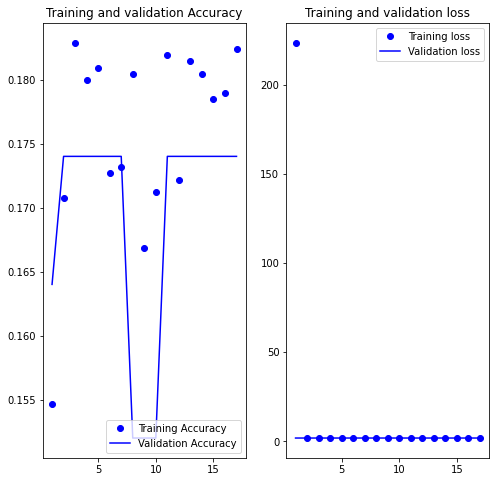

In [ ]:
#see the history of the training
history_dict = history.history

#plot the validation and training loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

#plot the validation and training accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy') #bo is for blue dot
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') #b is for solid blue line
plt.legend(loc="lower right")
plt.title('Training and validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_values, 'bo', label='Training loss') #bo is for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') #b is for solid blue line
plt.legend(loc="upper right")
plt.title('Training and validation loss')

plt.show()

### Train and Test Model - Augmented + Pre-trained Model (MobileNet) 224x224

####Prepare the data (224, 224)

In [ ]:
#Categories of plastic types 
Categories_2=['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC']

#Image size
IMG_SIZE_2 = 224

#Code adapted from the following sources:
#1. https://www.kaggle.com/code/ashutoshvarma/image-classification-using-svm-92-accuracy
#2. https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01

dataset_arr_2=[] #input array

#Loop through the categories
for i in Categories_2:
    print(f'loading... {i}') #display message to show that category is loading
    path=os.path.join(plasticimagedir,i) #join to the image directory
    class_index=Categories_2.index(i) #subdirectory name which is the inferred label
    class_len=len(os.listdir(path)) #get the number of files per category

    for img in os.listdir(path):
        try:
          img_array=cv2.imread(os.path.join(path,img))
          resized_array=cv2.resize(img_array,(IMG_SIZE_2, IMG_SIZE_2)) #resize images
          dataset_arr_2.append([resized_array,class_index])
        except Exception as e:
          pass
    print(f'loaded {i} successfully:', class_len) #display message to show that category has been loaded successfully

loading... HDPE
loaded HDPE successfully: 520
loading... LDPE
loaded LDPE successfully: 516
loading... OTHER
loaded OTHER successfully: 502
loading... PET
loaded PET successfully: 544
loading... PP
loaded PP successfully: 573
loading... PVC
loaded PVC successfully: 540


In [ ]:
#Shuffle the dataset
random.shuffle(dataset_arr_2)

X_pretrained=[] #array to store the image data
y_pretrained=[] #array to store the labels

#loop through the dataset array, and save the image data and labels into separate arrays
#remember in the intial for loop, we saved both the resized array and labels into the dataset array
for imgdata, label in dataset_arr_2:
    X_pretrained.append(imgdata)
    y_pretrained.append(label)

#Display the X and y arrays
y_pretrained=np.array(y_pretrained)
X_pretrained= np.array(X_pretrained)

print(y_pretrained.shape)
print(X_pretrained.shape)

(3195,)
(3195, 224, 224, 3)


In [ ]:
## cast as float and rescale from [0, 1]
X_pretrained = X_pretrained.astype('float32')/255

## encode with the convenient to_categorical function
# if you do not encode, the following error occurs: https://stackoverflow.com/questions/67650000/tensorflow-valueerror-shapes-none-1-and-none-10-are-incompatible
y_pretrained = to_categorical(y_pretrained)

#Split the dataset
x_train_pretrained,x_test_pretrained,y_train_pretrained,y_test_pretrained=train_test_split(X_pretrained,y_pretrained,test_size=0.20,random_state=77)

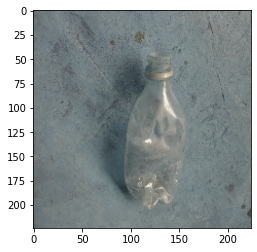

In [ ]:
plt.imshow(X_pretrained[1])

####Train the Model (224, 224)

In [ ]:
#Extracts all features from the pre-trained model except the last layer
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

#trainable = false freezes all layers except the last
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
#Train the model using the pre-trained model
model_seven = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(6, activation="softmax")
])

model_seven.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#optimser, loss and metrics are trained at compilation
model_seven.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
## training - fit input to data
history = model_seven.fit(x_train_pretrained, y_train_pretrained, epochs=30)

Epoch 1/30
80/80 [==============================] - 16s 45ms/step - loss: 0.9858 - accuracy: 0.6385
Epoch 2/30
80/80 [==============================] - 3s 41ms/step - loss: 0.5329 - accuracy: 0.8118
Epoch 3/30
80/80 [==============================] - 4s 45ms/step - loss: 0.4185 - accuracy: 0.8482
Epoch 4/30
80/80 [==============================] - 3s 41ms/step - loss: 0.3539 - accuracy: 0.8740
Epoch 5/30
80/80 [==============================] - 3s 41ms/step - loss: 0.3047 - accuracy: 0.8955
Epoch 6/30
80/80 [==============================] - 3s 41ms/step - loss: 0.2646 - accuracy: 0.9081
Epoch 7/30
80/80 [==============================] - 4s 44ms/step - loss: 0.2429 - accuracy: 0.9174
Epoch 8/30
80/80 [==============================] - 4s 45ms/step - loss: 0.2141 - accuracy: 0.9339
Epoch 9/30
80/80 [==============================] - 3s 42ms/step - loss: 0.1940 - accuracy: 0.9378
Epoch 10/30
80/80 [==============================] - 3s 41ms/step - loss: 0.1767 - accuracy: 0.9495
Epoch 11

In [ ]:
model_seven.evaluate(x_test_pretrained,y_test_pretrained)

20/20 [==============================] - 2s 64ms/step - loss: 0.5298 - accuracy: 0.8388


[0.5297636985778809, 0.8388106226921082]

In [ ]:
#Code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#print classification report for CNN
preds_mobilenet = np.round(model_seven.predict(x_test_pretrained), 0)

#print classification report
classification_metrics = metrics.classification_report(y_test_pretrained, preds_mobilenet, target_names = Categories_2)
print(classification_metrics)

20/20 [==============================] - 1s 53ms/step
              precision    recall  f1-score   support

        HDPE       0.82      0.75      0.78       106
        LDPE       0.91      0.93      0.92       104
       OTHER       0.85      0.84      0.85       103
         PET       0.87      0.83      0.85       117
          PP       0.77      0.74      0.76       113
         PVC       0.91      0.90      0.90        96

   micro avg       0.85      0.83      0.84       639
   macro avg       0.85      0.83      0.84       639
weighted avg       0.85      0.83      0.84       639
 samples avg       0.83      0.83      0.83       639



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Train and Test Model - Augmented + Pre-trained Model (ResNet50) 64x64

In [ ]:
#Extracts all features from the pre-trained model except the last layer
feature_extractor_model_2 = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5" #resnet50

#trainable = false freezes all layers except the last
pretrained_model_without_top_layer_2 = hub.KerasLayer(feature_extractor_model_2, trainable=True, 
                                                      arguments=dict(batch_norm_momentum=0.997), input_shape=(64, 64, 3))

In [ ]:
#Train the model using the pre-trained model
model_eight = tf.keras.Sequential([
  pretrained_model_without_top_layer_2,
  tf.keras.layers.Dense(6, activation="softmax")
])

model_eight.build((None, 64, 64, 3))
model_eight.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_9 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense_20 (Dense)            (None, 6)                 12294     
                                                                 
Total params: 23,577,094
Trainable params: 23,531,654
Non-trainable params: 45,440
_________________________________________________________________


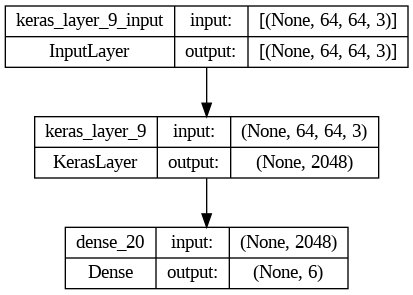

In [ ]:
#visualising the connectivity of the model/topology of the model
keras.utils.plot_model(model_eight, "resnet_classifier.png", show_shapes=True)

In [ ]:
#optimser, loss and metrics are trained at compilation
model_eight.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
## training - fit input to data
x_val = x_train_2[:500]
partial_x_train = x_train_2[500:]

y_val = y_train_2[:500]
partial_y_train = y_train_2[500:]

history = model_eight.fit(partial_x_train, partial_y_train, 
                         epochs=50, 
                         validation_data=(x_val, y_val))

Epoch 1/50
65/65 [==============================] - 32s 117ms/step - loss: 1.6354 - accuracy: 0.4898 - val_loss: 2.4643 - val_accuracy: 0.5320
Epoch 2/50
65/65 [==============================] - 5s 75ms/step - loss: 0.8258 - accuracy: 0.8161 - val_loss: 2.1998 - val_accuracy: 0.6220
Epoch 3/50
65/65 [==============================] - 6s 90ms/step - loss: 0.5112 - accuracy: 0.9193 - val_loss: 2.0730 - val_accuracy: 0.6480
Epoch 4/50
65/65 [==============================] - 6s 97ms/step - loss: 0.3884 - accuracy: 0.9645 - val_loss: 1.7684 - val_accuracy: 0.7320
Epoch 5/50
65/65 [==============================] - 8s 128ms/step - loss: 0.3369 - accuracy: 0.9762 - val_loss: 1.9798 - val_accuracy: 0.7460
Epoch 6/50
65/65 [==============================] - 4s 61ms/step - loss: 0.3287 - accuracy: 0.9737 - val_loss: 2.1111 - val_accuracy: 0.7420
Epoch 7/50
65/65 [==============================] - 4s 56ms/step - loss: 0.3158 - accuracy: 0.9796 - val_loss: 2.6378 - val_accuracy: 0.6880
Epoch 8/50

In [ ]:
model_eight.evaluate(x_test_2,y_test_2)

20/20 [==============================] - 0s 22ms/step - loss: 1.4582 - accuracy: 0.8466


[1.4582220315933228, 0.8466353416442871]

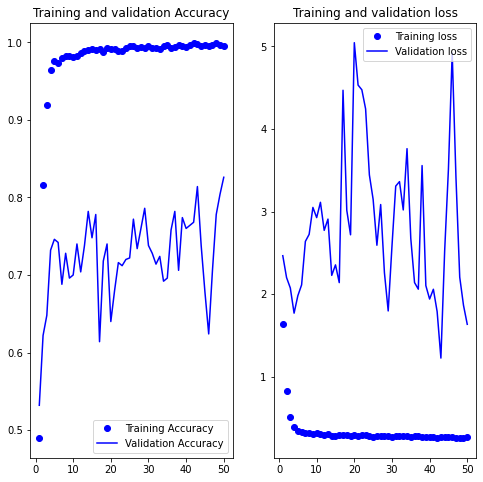

In [ ]:
#see the history of the training
history_dict = history.history

#plot the validation and training loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

#plot the validation and training accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy') #bo is for blue dot
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') #b is for solid blue line
plt.legend(loc="lower right")
plt.title('Training and validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_values, 'bo', label='Training loss') #bo is for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') #b is for solid blue line
plt.legend(loc="upper right")
plt.title('Training and validation loss')

plt.show()

In [ ]:
#Code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#print classification report for CNN
preds_2 = np.round(model_eight.predict(x_test_2), 0)

#print classification report
classification_metrics_2 = metrics.classification_report(y_test_2, preds_2, target_names = Categories)
print(classification_metrics_2)

20/20 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

        HDPE       0.86      0.76      0.81       104
        LDPE       0.80      0.94      0.87       103
       OTHER       0.83      0.90      0.87       100
         PET       0.76      0.86      0.81       109
          PP       0.91      0.78      0.84       115
         PVC       1.00      0.82      0.90       108

   micro avg       0.85      0.84      0.85       639
   macro avg       0.86      0.85      0.85       639
weighted avg       0.86      0.84      0.85       639
 samples avg       0.84      0.84      0.84       639



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


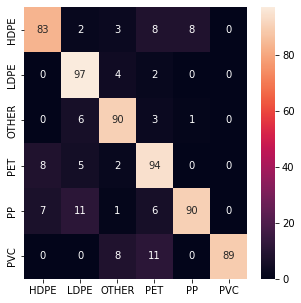

In [ ]:
#Categorical code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#Change into categorical variables
categorical_test_labels_2 = pd.DataFrame(y_test_2).idxmax(axis=1)
categorical_preds_2 = pd.DataFrame(preds_2).idxmax(axis=1)

#print the confusion matrix as an image
confmat_2 = confusion_matrix(categorical_test_labels_2, categorical_preds_2)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat_2 = pd.DataFrame(confmat_2, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot_2 = sns.heatmap(df_confmat_2, annot=True)

### Train and Test Model: Efficient B7 (64X64)

In [ ]:
#Extracts all features from the pre-trained model except the last layer
feature_extractor_model_3 = "https://tfhub.dev/google/efficientnet/b7/classification/1" #efficientb7

#trainable = false freezes all layers except the last
pretrained_model_without_top_layer_3 = hub.KerasLayer(feature_extractor_model_3, trainable=False, input_shape=(64, 64, 3))

In [ ]:
#Train the model using the pre-trained model
model_nine = tf.keras.Sequential([
  pretrained_model_without_top_layer_3,
  tf.keras.layers.Dense(6, activation="softmax")
])

model_nine.build((None, 64, 64, 3))
model_nine.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_10 (KerasLayer)  (None, 1000)             66658680  
                                                                 
 dense_21 (Dense)            (None, 6)                 6006      
                                                                 
Total params: 66,664,686
Trainable params: 6,006
Non-trainable params: 66,658,680
_________________________________________________________________


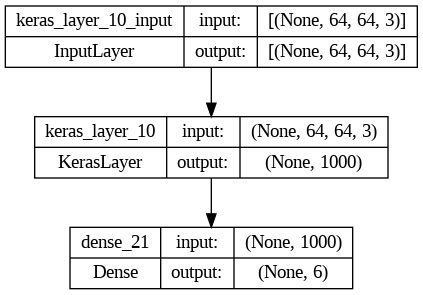

In [ ]:
#visualising the connectivity of the model/topology of the model
keras.utils.plot_model(model_nine, "efficientb7_classifier.png", show_shapes=True)

In [ ]:
#optimser, loss and metrics are trained at compilation
model_nine.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

## training - fit input to data
x_val = x_train_2[:500]
partial_x_train = x_train_2[500:]

y_val = y_train_2[:500]
partial_y_train = y_train_2[500:]

history = model_nine.fit(partial_x_train, partial_y_train, 
                         epochs=50, 
                         validation_data=(x_val, y_val))

Epoch 1/50
65/65 [==============================] - 37s 276ms/step - loss: 1.8041 - accuracy: 0.1877 - val_loss: 1.7629 - val_accuracy: 0.2360
Epoch 2/50
65/65 [==============================] - 6s 89ms/step - loss: 1.7351 - accuracy: 0.2461 - val_loss: 1.7165 - val_accuracy: 0.3040
Epoch 3/50
65/65 [==============================] - 6s 98ms/step - loss: 1.6937 - accuracy: 0.3001 - val_loss: 1.6839 - val_accuracy: 0.3000
Epoch 4/50
65/65 [==============================] - 8s 129ms/step - loss: 1.6578 - accuracy: 0.3312 - val_loss: 1.6495 - val_accuracy: 0.3720
Epoch 5/50
65/65 [==============================] - 5s 78ms/step - loss: 1.6268 - accuracy: 0.3750 - val_loss: 1.6332 - val_accuracy: 0.3800
Epoch 6/50
65/65 [==============================] - 5s 72ms/step - loss: 1.6024 - accuracy: 0.3920 - val_loss: 1.6076 - val_accuracy: 0.4020
Epoch 7/50
65/65 [==============================] - 5s 77ms/step - loss: 1.5753 - accuracy: 0.4105 - val_loss: 1.5895 - val_accuracy: 0.4020
Epoch 8/50

In [ ]:
model_nine.evaluate(x_test_2,y_test_2)

20/20 [==============================] - 2s 111ms/step - loss: 1.1253 - accuracy: 0.6385


[1.1252789497375488, 0.6384976506233215]

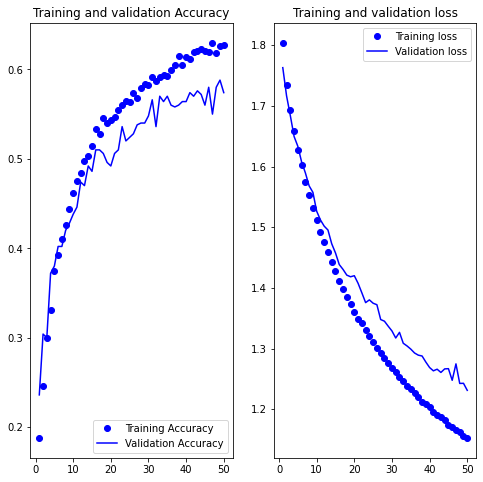

In [ ]:
#see the history of the training
history_dict = history.history

#plot the validation and training loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

#plot the validation and training accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy') #bo is for blue dot
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') #b is for solid blue line
plt.legend(loc="lower right")
plt.title('Training and validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_values, 'bo', label='Training loss') #bo is for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') #b is for solid blue line
plt.legend(loc="upper right")
plt.title('Training and validation loss')

plt.show()

In [ ]:
#Code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#print classification report for CNN
preds_3 = np.round(model_nine.predict(x_test_2), 0)

#print classification report
classification_metrics_3 = metrics.classification_report(y_test_2, preds_3, target_names = Categories)
print(classification_metrics_3)

20/20 [==============================] - 4s 61ms/step
              precision    recall  f1-score   support

        HDPE       0.66      0.18      0.29       104
        LDPE       0.77      0.42      0.54       103
       OTHER       0.84      0.31      0.45       100
         PET       0.81      0.20      0.32       109
          PP       0.40      0.03      0.06       115
         PVC       0.79      0.38      0.51       108

   micro avg       0.76      0.25      0.38       639
   macro avg       0.71      0.25      0.36       639
weighted avg       0.71      0.25      0.36       639
 samples avg       0.25      0.25      0.25       639



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


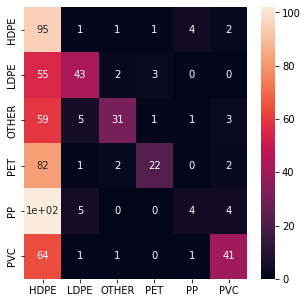

In [ ]:
#Categorical code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#Change into categorical variables
categorical_test_labels_3 = pd.DataFrame(y_test_2).idxmax(axis=1)
categorical_preds_3 = pd.DataFrame(preds_3).idxmax(axis=1)

#print the confusion matrix as an image
confmat_3 = confusion_matrix(categorical_test_labels_3, categorical_preds_3)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat_3 = pd.DataFrame(confmat_3, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot_3 = sns.heatmap(df_confmat_3, annot=True)

###Train and Test Model: MobileNet (64X64) ⭐⭐⭐⭐⭐

In [ ]:
#Extracts all features from the pre-trained model except the last layer
feature_extractor_model_4 = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_160/feature_vector/5" #mobilenet

#trainable = false freezes all layers except the last
pretrained_model_without_top_layer_4 = hub.KerasLayer(feature_extractor_model_4, trainable=True, 
                                                      arguments=dict(batch_norm_momentum=0.997), input_shape=(64, 64, 3))

In [ ]:
#Train the model using the pre-trained model
model_ten = tf.keras.Sequential([
  pretrained_model_without_top_layer_4,
  tf.keras.layers.Dense(6, activation="softmax")
])

model_ten.build((None, 64, 64, 3))
model_ten.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_11 (KerasLayer)  (None, 1024)             3228864   
                                                                 
 dense_22 (Dense)            (None, 6)                 6150      
                                                                 
Total params: 3,235,014
Trainable params: 3,213,126
Non-trainable params: 21,888
_________________________________________________________________


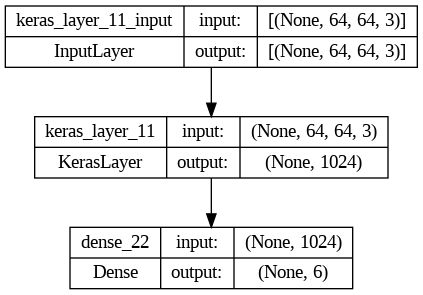

In [ ]:
#visualising the connectivity of the model/topology of the model
keras.utils.plot_model(model_ten, "mobilenet_classifier.png", show_shapes=True)

In [ ]:
#optimser, loss and metrics are trained at compilation
model_ten.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

## training - fit input to data
x_val = x_train_2[:500]
partial_x_train = x_train_2[500:]

y_val = y_train_2[:500]
partial_y_train = y_train_2[500:]

history = model_ten.fit(partial_x_train, partial_y_train, 
                         epochs=50, 
                         validation_data=(x_val, y_val))

Epoch 1/50
65/65 [==============================] - 13s 32ms/step - loss: 1.3426 - accuracy: 0.6026 - val_loss: 1.3264 - val_accuracy: 0.6040
Epoch 2/50
65/65 [==============================] - 2s 28ms/step - loss: 0.4217 - accuracy: 0.8940 - val_loss: 1.1307 - val_accuracy: 0.7000
Epoch 3/50
65/65 [==============================] - 2s 29ms/step - loss: 0.2471 - accuracy: 0.9635 - val_loss: 0.9488 - val_accuracy: 0.7660
Epoch 4/50
65/65 [==============================] - 2s 25ms/step - loss: 0.1992 - accuracy: 0.9830 - val_loss: 0.9742 - val_accuracy: 0.7800
Epoch 5/50
65/65 [==============================] - 2s 24ms/step - loss: 0.1690 - accuracy: 0.9878 - val_loss: 0.9320 - val_accuracy: 0.7860
Epoch 6/50
65/65 [==============================] - 2s 24ms/step - loss: 0.1577 - accuracy: 0.9912 - val_loss: 0.9614 - val_accuracy: 0.8020
Epoch 7/50
65/65 [==============================] - 2s 25ms/step - loss: 0.1506 - accuracy: 0.9942 - val_loss: 0.8140 - val_accuracy: 0.8240
Epoch 8/50
6

In [ ]:
model_ten.evaluate(x_test_2,y_test_2)

20/20 [==============================] - 0s 12ms/step - loss: 0.7524 - accuracy: 0.8936


[0.7523607611656189, 0.8935837149620056]

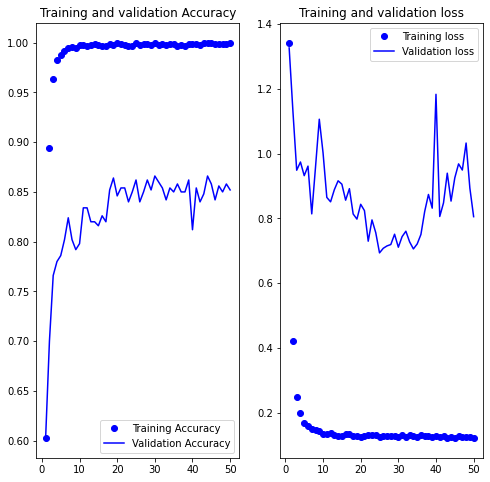

In [ ]:
#see the history of the training
history_dict = history.history

#plot the validation and training loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

#plot the validation and training accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy') #bo is for blue dot
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') #b is for solid blue line
plt.legend(loc="lower right")
plt.title('Training and validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_values, 'bo', label='Training loss') #bo is for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') #b is for solid blue line
plt.legend(loc="upper right")
plt.title('Training and validation loss')

plt.show()

In [ ]:
#Code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#print classification report for CNN
preds_4 = np.round(model_ten.predict(x_test_2), 0)

#print classification report
classification_metrics_4 = metrics.classification_report(y_test_2, preds_4, target_names = Categories)
print(classification_metrics_4)

20/20 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

        HDPE       0.89      0.89      0.89       104
        LDPE       0.84      0.91      0.87       103
       OTHER       0.91      0.93      0.92       100
         PET       0.92      0.83      0.88       109
          PP       0.92      0.87      0.89       115
         PVC       0.95      0.96      0.96       108

   micro avg       0.91      0.90      0.90       639
   macro avg       0.91      0.90      0.90       639
weighted avg       0.91      0.90      0.90       639
 samples avg       0.90      0.90      0.90       639



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


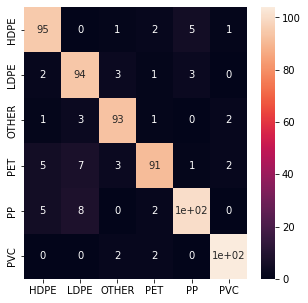

In [ ]:
#Categorical code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#Change into categorical variables
categorical_test_labels_4 = pd.DataFrame(y_test_2).idxmax(axis=1)
categorical_preds_4 = pd.DataFrame(preds_4).idxmax(axis=1)

#print the confusion matrix as an image
confmat_4 = confusion_matrix(categorical_test_labels_4, categorical_preds_4)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat_4 = pd.DataFrame(confmat_4, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot_4 = sns.heatmap(df_confmat_4, annot=True)